In [21]:
# This is a script to generate a single 2D map of double dot system 

import numpy as np
import imp
import sys
import os
import time
import copy
import multiprocessing as mp

sys.path.append(os.path.expanduser('~/quantum-ml/nanowire_model'))
import potential_profile
import markov
import exceptions

# wrapper around the base markov class functions
# this function also handles the NoBarrier and InvalidChargeState exceptions
def calculate_current(param):
    graph = param[0]
    physics_model = param[1]
    try:
        graph.physics = physics_model
        graph.tf.__init__(physics_model)
        graph.find_n_dot_estimate()
        graph.find_start_node()
        graph.generate_graph()
        return graph.get_output()
    except exceptions.NoBarrierState:
        output = {}
        output['current'] = graph.tf.short_circuit_current
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'ShortCircuit'
        return output
    except exceptions.InvalidChargeState:
        output = {}
        output['current'] = 0
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'NoDot'
        return output

physics_model = {}
# multiple of eV
physics_model['E_scale'] = 1
# multiple of nm
physics_model['dx_scale'] = 1
physics_model['kT'] = 1500e-6

# just initial param to generate the graph object
b1 = [-200e-3,get_random(-0.6),get_random(0.05),1]
d1 = [200e-3,get_random(-0.2),get_random(0.05),1]
b2 = [-250e-3,get_random(0.0),get_random(0.05),1]
d2 = [200e-3,get_random(0.2),get_random(0.05),1]
b3 = [-200e-3,get_random(0.6),get_random(0.05),1]

x = np.linspace(-1,1,100)
physics_model['x'] = x
physics_model['list_b'] = [b1,d1,b2,d2,b3]
physics_model['V'] = potential_profile.V_x_wire(x,physics_model['list_b'])


physics_model['K_onsite'] = get_random(25e-3)
physics_model['sigma'] = x[1] - x[0]
physics_model['x_0'] = 0.1*(x[1] - x[0])
physics_model['mu_l'] = (300.0e-3,300.1e-3)
physics_model['battery_weight'] = 10
physics_model['short_circuit_current'] = 1

graph_model = (2,1)
tf_strategy = 'simple'

graph = markov.Markov(graph_model,physics_model,tf_strategy)
graph.find_n_dot_estimate()

def get_random(mean,sigma_mean = 0.01):
    return np.random.normal(mean,sigma_mean*np.abs(mean))

N_v = 100
V_d_vec = np.linspace(50e-3,400e-3,N_v)
output_vec = []
input_vec = []
st = time.time()
for i in range(N_v):
    for j in range(N_v):
        d1[0] = V_d_vec[i]
        d2[0] = V_d_vec[j]
        physics_model['list_b'] = [b1,d1,b2,d2,b3]
        V = potential_profile.V_x_wire(x,physics_model['list_b'])
        physics_model['V'] = potential_profile.V_x_wire(x,[b1,b2,b3,d1,d2])
        input_vec += [physics_model.copy()]
        output_vec += [calculate_current((graph,physics_model))]
print("time",time.time() - st)

# store the data
# data is a list of dictonaries, with two keys : 'input' , 'output'
# input is a dict with three keys '
data = []
for i in range(len(output_vec)):
    inp = {}
    inp['graph_model'] = graph_model
    inp['tf_strategy'] = tf_strategy
    inp['physics_model'] = input_vec[i]
    data += [{'input' : inp,'output' : output_vec[i]}]

import datetime
dt = str(datetime.datetime.now()) 
np.save(os.path.expanduser('~/datadump/double_dot_' + str(N_v) + '_grid_' + dt + '.npy'),data)


time 375.3808650970459


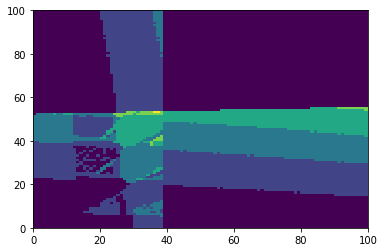

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
N_v = 100
data = np.load(os.path.join("/Users/sandesh/datadump/double_dot_100_grid_2017-06-26 00:28:38.456959.npy"))
plt.pcolor(np.array([np.sum(x['output']['charge_state']) for x in data]).reshape((N_v,N_v)))
#plt.pcolor(np.array([x['output']['current'] for x in data]).reshape((N_v,N_v)),vmax=1e-2)

In [36]:
data[0]['input']['physics_model']

{'E_scale': 1,
 'K_onsite': 0.025145650379316292,
 'V': array([ 0.09229866,  0.10835777,  0.12508351,  0.14254401,  0.16081889,
         0.18000199,  0.20020489,  0.22156151,  0.24423415,  0.26842146,
         0.29436893,  0.32238212,  0.35284218,  0.38621945,  0.42306871,
         0.46394963,  0.50908557,  0.55718901,  0.60225569,  0.62976149,
         0.62661266,  0.60071542,  0.56834784,  0.53789586,  0.51161777,
         0.48956888,  0.47124516,  0.45608622,  0.44360269,  0.43339346,
         0.42513359,  0.41855705,  0.41344062,  0.40959068,  0.40683485,
         0.40502455,  0.40407097,  0.40408611,  0.40582951,  0.41170655,
         0.4259702 ,  0.45043627,  0.48205904,  0.51789684,  0.55716452,
         0.60020027,  0.64744241,  0.69817857,  0.74762252,  0.78192114,
         0.78214761,  0.74830606,  0.69933174,  0.64908653,  0.60236486,
         0.55988259,  0.52118456,  0.48584538,  0.45438042,  0.42933156,
         0.41408378,  0.40782396,  0.40637362,  0.40696257,  0.408635